In [1]:
import pandas as pd

In [61]:
df = pd.read_csv('practice_addition_fnp2022-fincausal-task2.csv', sep = ';')

In [62]:
df

,Index,Text,Cause,Effect
0,0,The increase in net interest income was due pr...,a $152.9 billion increase in average outstandi...,The increase in net interest income
1,1,"NPAs increased $703 million year over year, pr...",PCI loans that would have been classified as n...,NPAs increased $703 million year over year
2,2,Additional increases in noninterest income wer...,higher insurance income driven by improved pro...,Additional increases in noninterest income
3,3,"During 2020, the Company also issued $6.5 bill...",The increase is due to net income in excess of...,"During 2020, the Company also issued $6.5 bill..."
4,4,The significant increases in earnings assets a...,"the Merger, as well as impacts from the COVID-...",The significant increases in earnings assets a...
...,...,...,...,...
533,533,We recorded a gain of $15.7 million for the ye...,the partial prepayment of the Wynn Macau Term ...,We recorded a $4.6 million loss on extinguishm...
534,534,We recorded a loss of $13.1 million and $3.2 m...,change in the fair value of an interest rate c...,We recorded a loss of $13.1 million and $3.2 m...
535,535,We recorded a $4.6 million loss on extinguishm...,the partial prepayment of the Wynn Macau Term ...,We recorded a $4.6 million loss on extinguishm...
536,536,"Accordingly, operating cash flows will be impa...","During the year ended December 31, 2020, the d...","Accordingly, operating cash flows will be impa..."


In [63]:
df.at[:,'Label'] = 'causal'

In [64]:
df[' Text'] = df[' Text'].astype('str')
df[' Cause'] = df[' Cause'].astype('str')
df[' Effect'] = df[' Effect'].astype('str')

In [65]:
import random as r
r.seed(81)
for i in range(135):
    index_one = r.randint(1,537)
    index_two = r.randint(1,537)
    df = pd.concat([df,pd.DataFrame([['-','-',df.loc[index_one][' Cause'],df.loc[index_two][' Cause'],'non_causal']], columns=df.columns)])

for i in range(135):
    index_one = r.randint(1,537)
    index_two = r.randint(1,537)
    df = pd.concat([df,pd.DataFrame([['-','-',df.loc[index_one][' Cause'],df.loc[index_two][' Effect'],'non_causal']], columns=df.columns)])

for i in range(135):
    index_one = r.randint(1,537)
    index_two = r.randint(1,537)
    df = pd.concat([df,pd.DataFrame([['-','-',df.loc[index_one][' Effect'],df.loc[index_two][' Effect'],'non_causal']], columns=df.columns)])

for i in range(135):
    index_one = r.randint(1,537)
    index_two = r.randint(1,537)
    df = pd.concat([df,pd.DataFrame([['-','-',df.loc[index_one][' Effect'],df.loc[index_two][' Cause'],'non_causal']], columns=df.columns)])
    

In [66]:
df = df.drop(columns=['Index'])

In [67]:
df = df.reset_index(drop=True)

In [68]:
s = set(df[' Cause'].astype('str').to_list() + df[' Effect'].astype('str').to_list())

In [69]:
len(s)

860

In [71]:
from bertopic import BERTopic

list_sentencest = list(s)

topic_model = BERTopic()
topics, probs = topic_model.fit_transform(list_sentencest)

In [ ]:
info_topic = topic_model.get_document_info(list_sentencest)
info_topic.head()

In [73]:
for index,row in df.iterrows():
    df.at[index,'Topic_Cause'] = ''
    df.at[index,'Topic_Effect'] = ''
    df.at[index,'Topic_Cause'] = info_topic[info_topic['Document'] == row[' Cause']]['Name'].iloc[0]
    df.at[index,'Topic_Effect'] = info_topic[info_topic['Document'] == row[' Effect']]['Name'].iloc[0]

In [ ]:
df

In [12]:
system_prompt = """You are an AI designed to extract key event components (5W1H: Who, What, When, Where, Why, How) from news articles. Your task is to analyze the given article and return only the extracted components in a structured JSON format. Each component should be concise and informative, based on the details provided in the article. The components to extract are as follows:


1. **Who**: Identify the individuals, groups, or organizations involved in the event. This may include specific people, roles, or organizations.
2. **What**: Summarize the core event or action described in the article.
3. **When**: Provide the exact time and/or date when the event occurred. If not explicitly stated, use the most relevant time frame mentioned.
4. **Where**: Specify the location where the event took place (e.g., city, country, landmark, etc.).
5. **Why**: If the article provides a reason or cause for the event, include it here. If not stated, leave this field blank or provide 'Not mentioned'.
6. **How**: Describe the method or manner in which the event occurred. This could refer to processes, mechanisms, or circumstances leading to the event.

Your output should be formatted as a JSON object. Below is an example of the expected output structure:

```json
{
  "Who": "Name or group of individuals or organizations involved in the event",
  "What": "Description of the event or action that occurred",
  "When": "Exact date and/or time when the event occurred (format YYYY-MM-DD)",
  "Where": "Location where the event took place (city, country, or specific place)",
  "Why": "The reason or cause behind the event",
  "How": "The method or manner in which the event occurred"
}
```"""

user_prompt = """
"Please read the following news article and extract the 5W1H components from the text. For each component, provide a brief and precise answer. Your response should be in the form of a JSON object with the following structure:

```json
{
  "Who": "Name or group of individuals or organizations involved in the event",
  "What": "Description of the event or action that occurred",
  "When": "Exact date and/or time when the event occurred (format YYYY-MM-DD)",
  "Where": "Location where the event took place (city, country, or specific place)",
  "Why": "The reason or cause behind the event (if provided in the text)",
  "How": "The method or manner in which the event occurred (if specified in the text)"
}
```

### Instructions for each component:
1. **Who**: Identify the individuals, groups, or organizations involved in the event. This can include names or roles (e.g., "president", "police", "protesters").
2. **What**: Summarize the core event or action described in the article. This is the primary event or situation that the article focuses on (e.g., "flood", "meeting", "discovery").
3. **When**: Extract the exact time and/or date the event occurred. If multiple dates or times are mentioned, provide the most relevant one.
4. **Where**: Identify the geographical location where the event took place. This could include cities, countries, or even specific buildings or landmarks.
5. **Why**: If the reason or cause behind the event is given in the article, provide a clear explanation here (e.g., "due to a natural disaster", "as a result of a political decision").
6. **How**: Describe the manner or method in which the event unfolded or occurred. This might be about the process, technique, or circumstances that led to the event (e.g., "due to a bomb explosion", "after negotiations").

Important: Your output must be in JSON format only. No additional text, explanations, or comments are allowed. Do not include any other information outside of the JSON structure.

Now, apply the same logic to the following news article.

### Text to analyze:
{text}
"""

In [13]:
import ollama
from ollama import chat
from ollama import ChatResponse

def LLM5W1H(model, system_prompt, user_prompt, num_ctx=10240, temperature=0):
  response: ChatResponse = chat(model=model, messages=[
    {
      'role': 'system',
      'content': system_prompt,
    },
    {
      'role': 'user',
      'content': user_prompt,
    },
  ],
                    options= {
                        'temperature': temperature,
                        'num_ctx': num_ctx,
                        'seed': 81
                    }
                                )
  return response['message']['content'].strip()

In [14]:
import json

def run_LLM_on_texts(df, column):
  L = []
  llm_model = 'gemma2:27b'
  for _,row in df.iterrows():
      texto = row[column]
      try_counter = 0
      while True:
        r = ''
        try:
          try_counter += 1
          r = LLM5W1H(llm_model,system_prompt,user_prompt.replace('{text}',texto))
          r = r.replace('```json', '')
          r = r.replace('```', '')
          json_obj = json.loads(r)
          print(llm_model)
          print(json_obj)
          L.append([texto,llm_model,json_obj])
          break
        except:
          print("Erro ao processar texto, tentando novamente... ollama is running?")
          print(r)
        if try_counter > 1:
          L.append([texto,llm_model,None])
          break
  return L

In [ ]:
L_effect = run_LLM_on_texts(df, ' Effect')
L_cause = run_LLM_on_texts(df, ' Cause')

In [134]:
df.at[:,'5w1h_effect'] = pd.DataFrame(L_effect)[2]
df.at[:,'5w1h_cause'] = pd.DataFrame(L_cause)[2]

In [136]:
df.to_csv('FinCausal.csv', index=False)

In [2]:
import json

def read_jsonl(file_name):
    records = []
    with open(file_name, "r") as r:
        for line in r:
            record = json.loads(line)
            records.append(record)
    return records

In [3]:
import pandas as pd
en_train_records = read_jsonl("Headlines/en/full/train.jsonl")
en_val_records = read_jsonl("Headlines/en/full/val.jsonl")
en_test_records = read_jsonl("Headlines/en/full/test.jsonl")
en_records = en_train_records + en_val_records + en_test_records
df_headlines = pd.DataFrame(en_records)

In [4]:
df_headlines.head()

,full_result,full_agreement,full_ds_result,full_ds_confidence,simple_result,simple_agreement,simple_ds_result,simple_ds_confidence,left_title,right_title,left_url,right_url,left_timestamp,right_timestamp,id,has_link,label
0,left_right_cause,0.7,left_right_cause,0.999951,left_right,0.7,left_right,0.999806,Indian government brushes off Indian tax offic...,Inquiry against 50 IRS officers over suggestin...,https://www.moneycontrol.com/news/business/eco...,https://www.moneycontrol.com/news/business/eco...,1587934800,1587934800,en_tg_1659,1,3
1,right_left_cause,0.8,right_left_cause,0.999998,right_left,0.8,right_left,0.999998,Insensitive or lost in translation? Twitter we...,Coronavirus: Why should I give money to lower-...,https://scroll.in/field/960310/insensitive-or-...,https://scroll.in/field/960307/coronavirus-why...,1587962640,1587946740,en_tg_1144,1,4
2,bad,0.8,bad,0.999995,not_cause,1.0,not_cause,0.999966,Why Reliance Industries share price has gained...,IndusInd Bank stock rises over 6% ahead of Q4 ...,https://www.businesstoday.in/markets/company-s...,https://www.businesstoday.in/markets/company-s...,1587965880,1587954720,en_tg_976,1,0
3,rel,0.8,rel,0.999951,not_cause,1.0,not_cause,0.999945,Meizu 17 teaser poster confirms 64MP Sony IMX6...,Meizu 17 Pro has Super wireless mCharge support,https://www.gizmochina.com/2020/04/27/meizu-17...,https://www.gizmochina.com/2020/04/27/meizu-17...,1587956479,1587968663,en_tg_878,1,2
4,bad,0.9,bad,1.000000,not_cause,1.0,not_cause,0.999991,10 things you need to know before the opening ...,'One of the most ridiculous deals that I've ev...,https://markets.businessinsider.com/news/stock...,https://markets.businessinsider.com/news/stock...,1587971880,1587955500,en_tg_519,1,0


In [5]:
d = {' Cause' : [], ' Effect': [], 'Label': []}

In [6]:
for index, row in df_headlines.iterrows():
    if row['simple_result'] == 'not_cause':
        d[' Cause'].append(row['left_title'])
        d[' Effect'].append(row['right_title'])
        d['Label'].append('non_causal')
    elif row['simple_result'] == 'left_right':
        d[' Cause'].append(row['left_title'])
        d[' Effect'].append(row['right_title'])
        d['Label'].append('causal')
    elif row['simple_result'] == 'right_left':
        d[' Cause'].append(row['right_title'])
        d[' Effect'].append(row['left_title'])
        d['Label'].append('causal')

In [7]:
df_headlines = pd.DataFrame(d)
df_headlines

,Cause,Effect,Label
0,Indian government brushes off Indian tax offic...,Inquiry against 50 IRS officers over suggestin...,causal
1,Coronavirus: Why should I give money to lower-...,Insensitive or lost in translation? Twitter we...,causal
2,Why Reliance Industries share price has gained...,IndusInd Bank stock rises over 6% ahead of Q4 ...,non_causal
3,Meizu 17 teaser poster confirms 64MP Sony IMX6...,Meizu 17 Pro has Super wireless mCharge support,non_causal
4,10 things you need to know before the opening ...,'One of the most ridiculous deals that I've ev...,non_causal
...,...,...,...
2507,GTA 5 free to download and keep from the Epic ...,GTA Online hit by outages following Epic Games...,causal
2508,Giants’ DeAndre Baker to be released on bail a...,DeAndre Baker’s bail amount may mean case is u...,causal
2509,Highlanders' favourite son NOT returning for n...,Crusaders boosted with news of Whitelock clear...,non_causal
2510,"As he talked layoffs, de Blasio spent $2 milli...",De Blasio’s overspending can only discourage C...,causal


<Axes: >

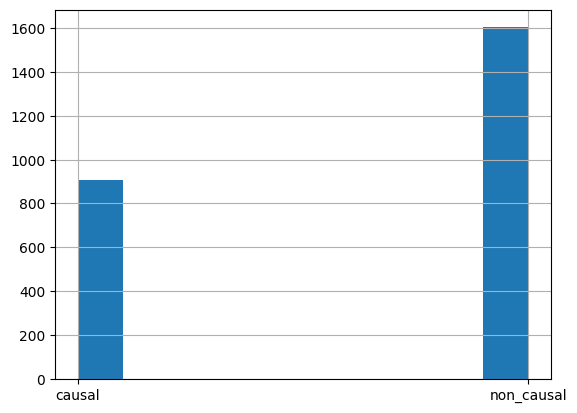

In [8]:
df_headlines.Label.hist()

In [9]:
s = set(df_headlines[' Cause'].astype('str').to_list() + df_headlines[' Effect'].astype('str').to_list())

In [10]:
len(s)

4463

In [ ]:
from bertopic import BERTopic

list_sentencest = list(s)

topic_model = BERTopic()
topics, probs = topic_model.fit_transform(list_sentencest)
info_topic = topic_model.get_document_info(list_sentencest)
info_topic.head()

In [16]:
for index,row in df_headlines.iterrows():
    df_headlines.at[index,'Topic_Cause'] = ''
    df_headlines.at[index,'Topic_Effect'] = ''
    df_headlines.at[index,'Topic_Cause'] = info_topic[info_topic['Document'] == row[' Cause']]['Name'].iloc[0]
    df_headlines.at[index,'Topic_Effect'] = info_topic[info_topic['Document'] == row[' Effect']]['Name'].iloc[0]

In [ ]:
df_headlines.tail()

In [ ]:
L_cause = run_LLM_on_texts(df_headlines, ' Cause')

In [ ]:
L_effect = run_LLM_on_texts(df_headlines, ' Effect')

In [ ]:
df_headlines.at[:,'5w1h_effect'] = pd.DataFrame(L_effect)[2]
df_headlines.at[:,'5w1h_cause'] = pd.DataFrame(L_cause)[2]

In [66]:
df_headlines.loc[~(df_headlines['5w1h_cause'].notnull())]

,Cause,Effect,Label,Topic_Cause,Topic_Effect,5w1h_effect,5w1h_cause
782,St John's Market legend dies from coronavirus ...,Heartbroken family of St John's Market legend ...,causal,28_toll_deaths_uk_death,-1_to_covid19_of_coronavirus,"{'Who': 'Family of a market trader', 'What': '...",None


In [68]:
df_headlines.loc[~(df_headlines['5w1h_effect'].notnull())]

,Cause,Effect,Label,Topic_Cause,Topic_Effect,5w1h_effect,5w1h_cause
922,"""Young Thug & Chris Brown Set It Off On """"Say ...","""The Best Young Thug & Chris Brown Lyrics On ""...",non_causal,-1_to_covid19_of_coronavirus,-1_to_covid19_of_coronavirus,None,"{'Who': 'Young Thug and Chris Brown', 'What': ..."


In [69]:
df_headlines.to_csv('Headlines.csv', index=False)

In [73]:
df_twitter = pd.read_csv('twitter-causal-dataset.csv')
df_twitter = df_twitter.rename(columns={'cause': ' Cause', 'effect': ' Effect', 'label': 'Label'})
df_twitter

,Cause,Effect,Label
0,i ned to be front and centre,it’s al about me,not-causal
1,families truly suport girl-child,we can se that sky to is not the limit,causal
2,blinding youth with pelet guns was a #comonwea...,india would win a gold every hour,not-causal
3,they were so intolerant to an individuals thou...,they cant telecast #comonwealthgames2018 medal...,causal
4,you can't wait until then,you can watch it here:,causal
...,...,...,...
911,an injury #gc2018 #gc2018wrestling,was ruled out of the final,causal
912,it’s ben shown on chanel 7 only,if it’s on 7mate or seven7 then you gota pay,not-causal
913,new zealand double their,2-0 after a goalmouth scramble,not-causal
914,they are drawing atention to themselves and th...,we aren't harasing indigenous for crimes - we ...,not-causal


In [74]:
s = set(df_twitter[' Cause'].astype('str').to_list() + df_twitter[' Effect'].astype('str').to_list())
len(s)

1772

In [ ]:
from bertopic import BERTopic

list_sentencest = list(s)

topic_model = BERTopic()
topics, probs = topic_model.fit_transform(list_sentencest)
info_topic = topic_model.get_document_info(list_sentencest)

for index,row in df_twitter.iterrows():
    df_twitter.at[index,'Topic_Cause'] = ''
    df_twitter.at[index,'Topic_Effect'] = ''
    df_twitter.at[index,'Topic_Cause'] = info_topic[info_topic['Document'] == row[' Cause']]['Name'].iloc[0]
    df_twitter.at[index,'Topic_Effect'] = info_topic[info_topic['Document'] == row[' Effect']]['Name'].iloc[0]
    
df_twitter.tail()

In [ ]:
L_cause = run_LLM_on_texts(df_twitter, ' Cause')
L_effect = run_LLM_on_texts(df_twitter, ' Effect')

In [81]:
df_twitter.at[:,'5w1h_effect'] = pd.DataFrame(L_effect)[2]
df_twitter.at[:,'5w1h_cause'] = pd.DataFrame(L_cause)[2]

In [82]:
df_twitter.to_csv('Twitter.csv', index=False)

In [86]:
df_risk = pd.read_csv('risk-models-benchmark-v1.csv')
df_risk

,Statement 1,Statement 2,label
0,new competitors [2],increasing profits for our clients [13],causal
1,new competitors [2],"increased speed efficiency, and lower cost [11]",causal
2,"increased speed efficiency, and lower cost [11]",increasing profits for our clients [13],causal
3,"increased speed efficiency, and lower cost [11]",increasing profits for our clients [13],causal
4,changing market driving the needs for new busi...,increased importance of bundling products [16],causal
...,...,...,...
799,increased interest rate [329],increase in possibility of FCPA violation [189],non_causal
800,increasing size of IT market [301],substituting or adjacent industries prevailing...,non_causal
801,local business motivated to cut cost to be mor...,decreased talent in workforce [115],non_causal
802,increased motivation for entrepreneurs [109],decrease in data privacy regulations [297],non_causal


In [89]:
df_risk = df_risk.rename(columns={'Statement 1': ' Cause', 'Statement 2': ' Effect', 'label': 'Label'})
df_risk

,Cause,Effect,Label
0,new competitors [2],increasing profits for our clients [13],causal
1,new competitors [2],"increased speed efficiency, and lower cost [11]",causal
2,"increased speed efficiency, and lower cost [11]",increasing profits for our clients [13],causal
3,"increased speed efficiency, and lower cost [11]",increasing profits for our clients [13],causal
4,changing market driving the needs for new busi...,increased importance of bundling products [16],causal
...,...,...,...
799,increased interest rate [329],increase in possibility of FCPA violation [189],non_causal
800,increasing size of IT market [301],substituting or adjacent industries prevailing...,non_causal
801,local business motivated to cut cost to be mor...,decreased talent in workforce [115],non_causal
802,increased motivation for entrepreneurs [109],decrease in data privacy regulations [297],non_causal


In [90]:
s = set(df_risk[' Cause'].astype('str').to_list() + df_risk[' Effect'].astype('str').to_list())
len(s)

223

In [ ]:
from bertopic import BERTopic

list_sentencest = list(s)

topic_model = BERTopic()
topics, probs = topic_model.fit_transform(list_sentencest)
info_topic = topic_model.get_document_info(list_sentencest)
info_topic.head()


for index,row in df_risk.iterrows():
    df_risk.at[index,'Topic_Cause'] = ''
    df_risk.at[index,'Topic_Effect'] = ''
    df_risk.at[index,'Topic_Cause'] = info_topic[info_topic['Document'] == row[' Cause']]['Name'].iloc[0]
    df_risk.at[index,'Topic_Effect'] = info_topic[info_topic['Document'] == row[' Effect']]['Name'].iloc[0]
    
    
df_risk.tail()

In [ ]:
L_cause = run_LLM_on_texts(df_risk, ' Cause')
L_effect = run_LLM_on_texts(df_risk, ' Effect')

In [94]:
df_risk.at[:,'5w1h_effect'] = pd.DataFrame(L_effect)[2]
df_risk.at[:,'5w1h_cause'] = pd.DataFrame(L_cause)[2]

In [95]:
df_risk.to_csv('Risk.csv', index=False)